In [11]:
import os

directory = "D:\\Code\\AI\\Model\\NumberRecognitionModel"
# directory = "Users/danielnguyen/Repo/AI/Model/NumberRecognitionModel"

versions_list = sorted([int(version.replace('version', '')) for version in os.listdir(directory)])
latest_version = versions_list[-1]
new_version = latest_version + 1

new_version_path = 'version{}'.format(new_version)

path = os.path.join(directory, new_version_path)

os.makedirs(path)

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

Found 32680 images belonging to 10 classes.
Found 8164 images belonging to 10 classes.


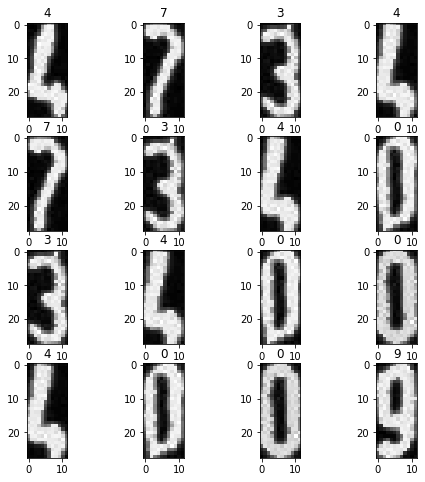

In [13]:
ds = ImageDataGenerator(
    rescale=1.0/255, 
    validation_split=0.2,
    fill_mode='constant',
    cval=0
)

train_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=128,
    subset='training',
    color_mode='grayscale',
    class_mode='sparse'
)

validation_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=128,
    subset='validation',
    color_mode='grayscale',
    class_mode='sparse'
)

input_shape = train_ds[0][0][0].shape

plt.rcParams["figure.figsize"] = (8,8)
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(validation_ds[0][0][i + j], cmap='gray')
        axs[i, j].set_title(int(validation_ds[0][1][i + j]))

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Conv2D(8, (3,3), activation='elu',
                        kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                        padding='same'),
    tf.keras.layers.Conv2D(8, (3,3), activation='elu',
                        kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                        padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='elu',
                        kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                        padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='elu', 
                        kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                        padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 12, 8)         80        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 12, 8)         584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 12, 8)         32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 6, 8)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 6, 32)         2336      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 6, 32)         128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 3, 32)         

In [16]:
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('val_accuracy') >= 0.999 and logs.get('accuracy') >= 0.999) :
            print('\nReached 99% accuracy so stopping training')
            self.model.stop_training = True

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='D:\\Code\\AI\\Model\\NumberRecognitionModel\\version10\\version10.hdf5',
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True)

In [17]:
callback = stopCallback()

history = model.fit(train_ds, 
                    epochs=200, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=validation_ds)

Epoch 1/200
256/256 [==============================] - 33s 127ms/step - loss: 0.1855 - accuracy: 0.9726 - val_loss: 3.7725 - val_accuracy: 0.0382
Epoch 2/200
256/256 [==============================] - 28s 108ms/step - loss: 0.0782 - accuracy: 0.9972 - val_loss: 0.2134 - val_accuracy: 0.9738
Epoch 3/200
256/256 [==============================] - 29s 113ms/step - loss: 0.0701 - accuracy: 0.9982 - val_loss: 0.0678 - val_accuracy: 0.9979
Epoch 4/200
256/256 [==============================] - 24s 95ms/step - loss: 0.0640 - accuracy: 0.9986 - val_loss: 0.0624 - val_accuracy: 0.9983
Epoch 5/200
256/256 [==============================] - 24s 95ms/step - loss: 0.0588 - accuracy: 0.9987 - val_loss: 0.0572 - val_accuracy: 0.9984
Epoch 6/200
256/256 [==============================] - 24s 92ms/step - loss: 0.0541 - accuracy: 0.9988 - val_loss: 0.0537 - val_accuracy: 0.9982
Epoch 7/200
256/256 [==============================] - 24s 95ms/step - loss: 0.0495 - accuracy: 0.9991 - val_loss: 0.0486 - val

KeyboardInterrupt: 

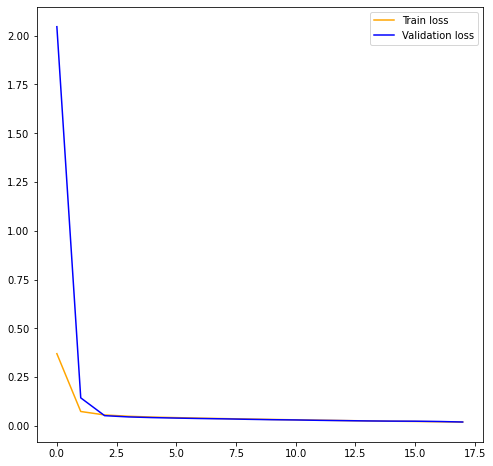

In [ ]:
plt.plot(history.history['loss'], color='orange', label='Train loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')
plt.legend()
plt.show()

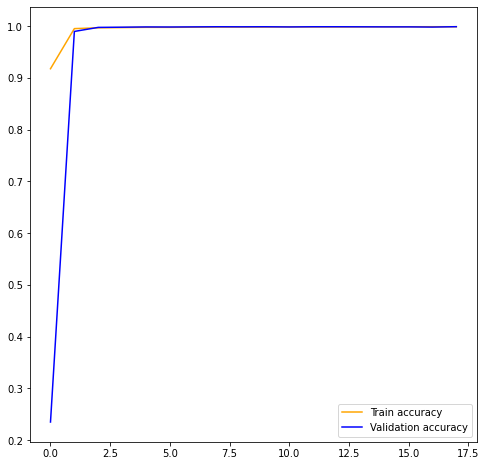

In [ ]:
plt.plot(history.history['accuracy'], color='orange', label='Train accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation accuracy')
plt.legend()
plt.show()

# Save the model into Model folder for later usage

In [ ]:
%%writefile {path}\model.py

import tensorflow as tf

def create_model() :
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_shape),
        tf.keras.layers.Conv2D(32, (3,3), activation='elu',
                            kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                            padding='same'),
        tf.keras.layers.Conv2D(32, (3,3), activation='elu',
                            kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='elu',
                            kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='elu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

Writing D:\Code\AI\Model\NumberRecognitionModel\version10\model.py
